# DLPFC dataset (151674)

We analyzed the 151674 section of human dorsolateral prefrontal cortex (DLPFC) dataset. DLPFC with 12 tissue slices and its annotation can be obtained from the package spatialLIBD (http://research.libd.org/spatialLIBD/). 

## 1. Import packages

In [1]:
from matplotlib import pyplot as plt
from DeepGFT.utils import *
from DeepGFT.genenet import obtain_genenet
from DeepGFT.train import *
import torch
import scanpy as sc
import warnings
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score, homogeneity_score
os.environ['R_HOME'] = '/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/R'
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_all(2023)

/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Read data

In [2]:
name = '151674'

# Read data
path = '/fs/ess/PAS1475/Jixin/DeepGFT_proj/'
adata = sc.read_visium(path + 'data/10x_Visium/DLPFC/' + name, count_file='filtered_feature_bc_matrix.h5')
ground_truth = sc.read_csv(path + 'data/10x_Visium/DLPFC/ground_truth/' + name + '_annotation.csv', dtype='str')
adata.obs['ground_truth'] = ground_truth.X

## 3. Data processing, including filtering genes and identifying svgs

In [3]:
# Data preprocessing
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)
adata, adata_raw = svg(adata, svg_method='gft_top', n_top=3000)

## 4. Construct network and GFT

Construct spot-spot network and gene co-expression network, and the graph Fourier transform was performed respectively. Obtain signal features of spots and genes.

In [4]:
# Build spotnet and genenet
obtain_spotnet(adata, knn_method='Radius', rad_cutoff=150)
gene_freq_mtx, gene_eigvecs_T, gene_eigvals = f2s_gene(adata, gene_signal=1500, c1=0.05)
obtain_genenet(adata)
spot_freq_mtx, spot_eigvecs_T, spot_eigvals = f2s_spot(adata, spot_signal=1500, middle=3, c2=0.005)
obtain_pre_spotnet(adata, adata_raw)

gene edges 24534 spots 3673


## 5. Train GAT module

In [5]:
res, lamda, emb_spot, _, attention = train_spot(adata, gene_freq_mtx, gene_eigvecs_T, spot_freq_mtx, spot_eigvecs_T,
                                                alpha=20, device=device, epoch_max=600)

spot*signal train


100%|██████████| 600/600 [00:31<00:00, 19.01it/s]


## 6. Downstream analysis

### Spatial cluster

In [6]:
adata.obsm['emb'] = emb_spot
sc.pp.neighbors(adata, use_rep='emb')
cluster_num = 5 if name in ['151669', '151670', '151671', '151672'] else 7
adata = mclust_R(adata, used_obsm='emb', num_cluster=cluster_num)
obs_df = adata.obs.dropna()
NMI_score = normalized_mutual_info_score(obs_df['mclust'], obs_df['ground_truth'], average_method='max')
HS_score = homogeneity_score(obs_df['mclust'], obs_df['ground_truth'])
adata.obs['domain'] = adata.obs['mclust'].copy()
new_type = refine_label(adata, radius=30, key='domain')
adata.obs['domain'] = new_type
ARI_score = adjusted_rand_score(adata.obs['domain'], obs_df['ground_truth'])
print('ARI:', ARI_score)
print('NMI:', NMI_score)
print('HS:', HS_score)

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/R
INFO:rpy2.situation:R library path: /apps/cuda/11.6.1/lib64
INFO:rpy2.situation:LD_LIBRARY_PATH: /apps/cuda/11.6.1/lib64
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
ARI: 0.65759767801712
NMI: 0.7090744314751084
HS: 0.7090744314751084


... storing 'ground_truth' as categorical
... storing 'domain' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


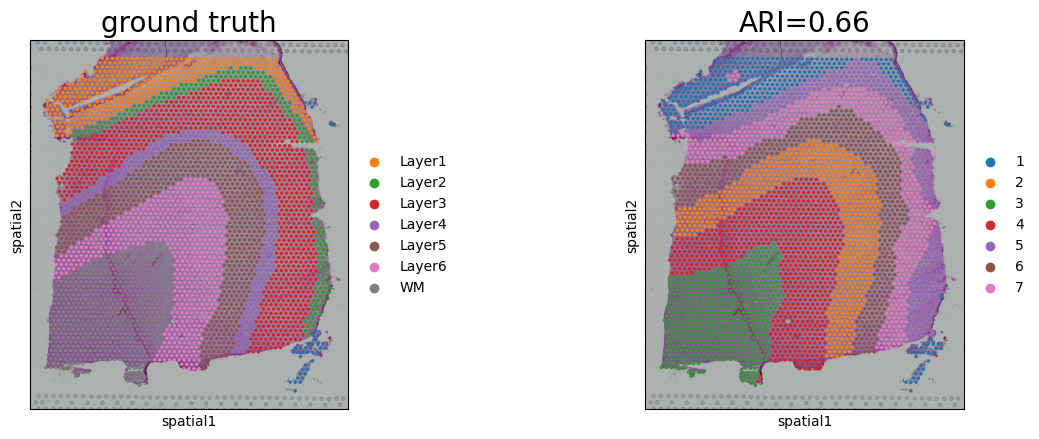

In [7]:
plt.rcParams.update({'axes.titlesize':20})
sc.pl.spatial(adata, color=["ground_truth", "domain"], title=['ground truth', 'ARI=%.2f' % ARI_score])

### Gene denoise

In [8]:
# Denoising
res_denoising, att = denoising(res, adata.uns['spotnet_adj'], attention[:, 0])
adata_res = adata.copy()
adata_res.X = res_denoising
svgs = ['HPCAL1', 'ENC1', 'CCK', 'PCP4', 'MOBP']

Before noise reduction


... storing 'ground_truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


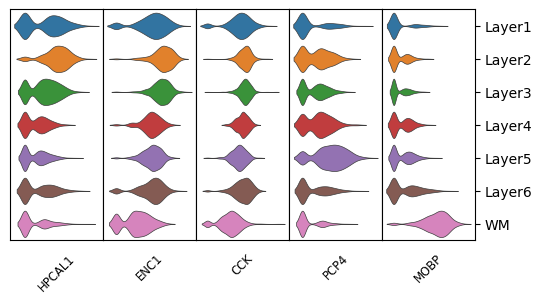

After noise reduction


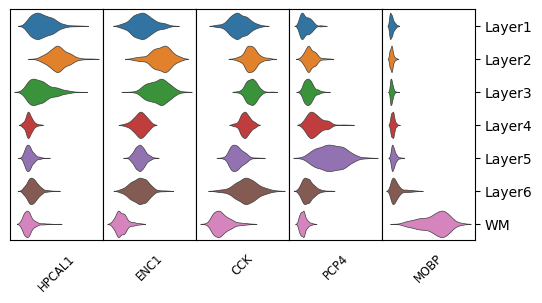

[<Axes: xlabel='HPCAL1'>,
 <Axes: xlabel='ENC1'>,
 <Axes: xlabel='CCK'>,
 <Axes: xlabel='PCP4'>,
 <Axes: xlabel='MOBP'>]

In [9]:
import scanyuan as scy
adata_raw = adata_raw[adata_raw.obs['ground_truth'] != '']
adata_res = adata_res[adata_res.obs['ground_truth'] != '']
print('Before noise reduction')
scy.stacked_violin_t(adata_raw, svgs, figsize=[6, 3], groupby='ground_truth')
print('After noise reduction')
scy.stacked_violin_t(adata_res, svgs, figsize=[6, 3], groupby='ground_truth')

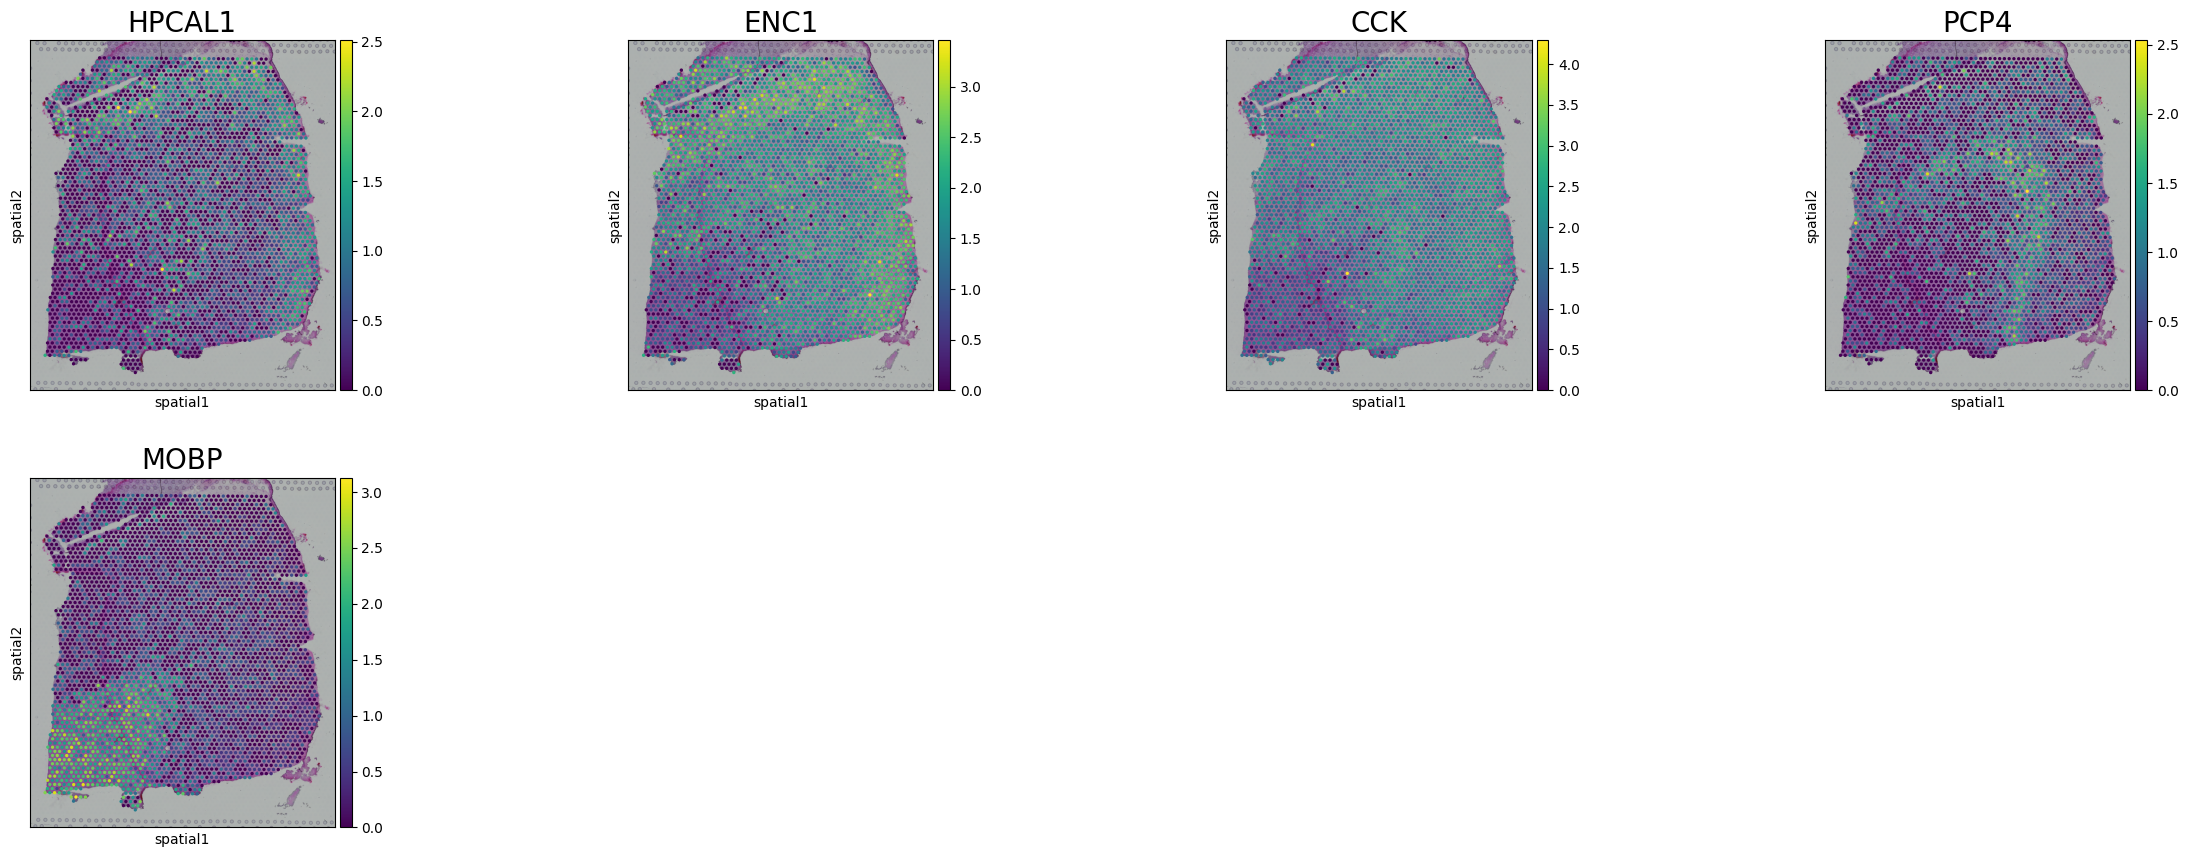

In [10]:
# Before noise reduction
sc.pl.spatial(adata_raw, color=svgs)

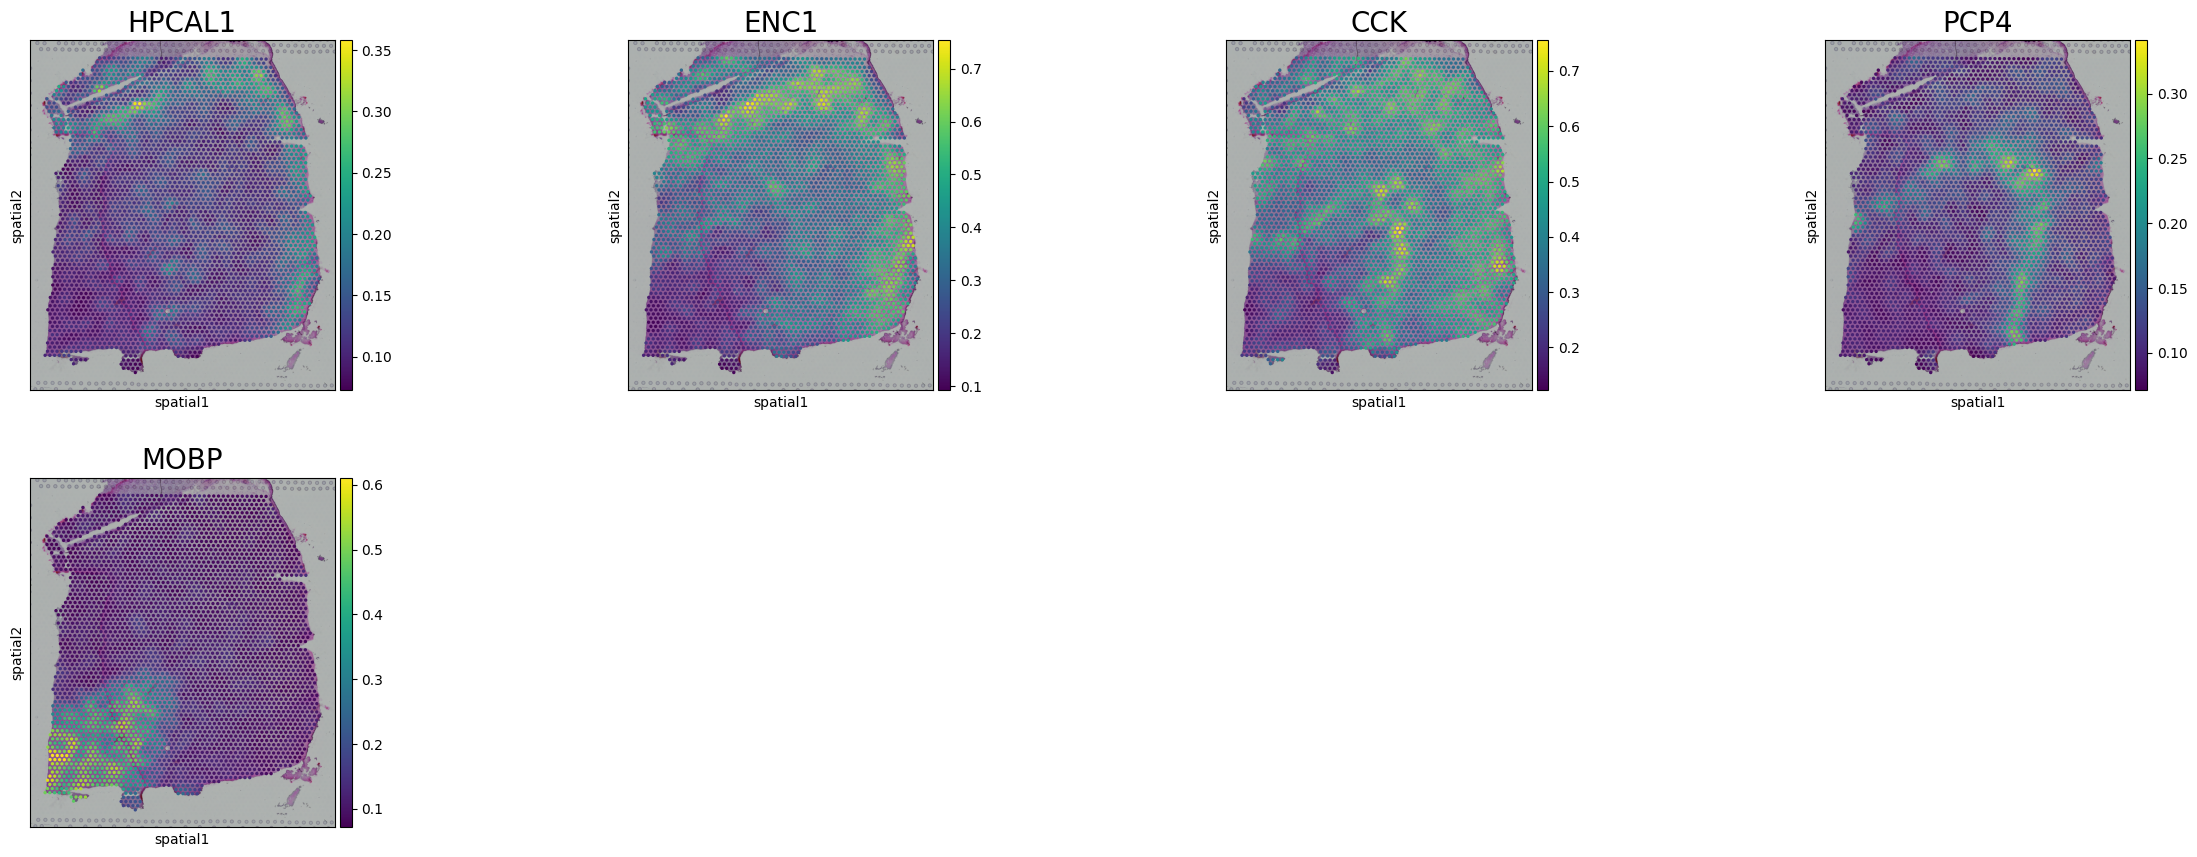

In [11]:
# After noise reduction
sc.pl.spatial(adata_res, color=svgs)